# Model training lab

This is the notebook for loading and training models.
Furthermore it provides simple documentation for different approaches used for training a model.

Run the command below to see command-completion on pressing `TAB`.

## Prerequisits

In [1]:
# Imports
import os
import warnings
import tools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from matplotlib import pyplot



# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Root CSV files directory
dirname = "./data/"  

# Constant frame count.
frames = 100

## Preparation Stage
### Load data and normalize
For training it's required to extend/reduce every dataset to n frames, where n is `frames`.

In [2]:
listfile = os.listdir(dirname)
data = []
for wordname in listfile:
    if wordname == ".DS_Store":
        continue
    for csv in os.listdir(dirname + wordname):
        filepath = os.path.join(dirname, wordname, csv)
        content = pd.read_csv(filepath, sep=';')
        content = content.reindex(list(range(0, frames)), fill_value=0.0)
        content.fillna(0.0, inplace = True) 
        data.append((wordname, content))


In [ ]:
# Print the content of the first dataframe
data[10][0]

### Split data
Split the dataset up into the following segments:
1. Training Data: 60%
2. Validation Data: 20%
3. Test Data: 20%


In [3]:
features = [n[1] for n in data]
features = [f.to_numpy() for f in features]
labels = [n[0] for n in data]
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=42)

In [ ]:
def printCountDataSets(dataset):
    wortCounter = []
    #Liste mit einmaligen Labels erstellen
    labels = sorted(set(dataset), key=dataset.index)
    #Liste nochmal Alphabetisch sortieren
    labels = sorted(labels)
    for label in labels:
        wortCounter.append(0)
    for row in dataset:
        for i in range(len(labels)):
            if str(labels[i]).startswith(row):
                wortCounter[i] += 1
    for i in range(len(labels)):
        print(labels[i], ': ', wortCounter[i], end =";  ")
    print(' ')        
        
print('Alle Klassensätze')
printCountDataSets(labels)
print('Trainings Klassensätze')
printCountDataSets(y_train)
print('Validation Klassensätze')
printCountDataSets(y_val)  
print('Test Klassensätze')
printCountDataSets(y_test) 

In [ ]:
# Display data distribution
print("Total:", len(labels))
print("Training:", len(y_train), len(y_train) / len(labels) * 100)
print("Val:", len(y_val), len(y_val) / len(labels) * 100)
print("Test:", len(y_test), len(y_test) / len(labels) * 100)

### Tokenize (One Hot)

In [4]:
tokenizer = tools.tokenize(dirname)
print(tokenizer.word_index)

with open('tokens_json.txt', 'w') as outfile:
    outfile.write(tokenizer.to_json())

encoded_train=tokenizer.texts_to_sequences([y_train])[0]
encoded_val=tokenizer.texts_to_sequences([y_val])[0]
encoded_test=tokenizer.texts_to_sequences([y_test])[0]

y_train = to_categorical(encoded_train)
y_val = to_categorical(encoded_val)
y_test = to_categorical(encoded_test)

print(y_train)

{'computer': 1, 'deutschland': 2, 'hallo': 3, 'welt': 4}
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [5]:
# Making numpy arrays
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [ ]:
print(x_train)

## Training Stage
Configure the model and train it.

Metrics:
<div float="right">
    <img src="assets/accuracy.png" width="400"> 
    <img src="assets/precision_recall_formula.png" width="400">
</div>
<img src="assets/precision_recall.png" width="1000">

### Configure model
Configures the model with the specified parameters.

#### LSTM

In [ ]:
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(layers.LSTM(32))  # return a single vector of dimension 32
#model.add(layers.LSTM(16))  # return a single vector of dimension 32
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

### or
#### Bidirectional LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(100, 86)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

### or
#### Simple RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(200, 42)))
model.add(Dense(64, activation="softmax")) #softmax, linear 어떤걸 기준으로 하지
model.add(Dense(128, activation="linear")) #softmax, linear 어떤걸 기준으로 하지
model.add(Dense(21))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### or
#### <span style="color:blue"> Hyperparametertuned LSTM </span>
##### Here it is necessary to install the Keras-Tuner Module by executing:
#####  <span style="color:green"> via Conda:</span>
conda install -c conda-forge keras-tuner
#####  <span style="color:green"> for pip:</span>
pip install keras-tuner


In [20]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from time import time, strftime


starttime= strftime("%Y_%m_%d_%H%M%S")
#LOG_DIR = "C:\ML\Optimization_"f"{starttime}"
LOG_DIR = "./Optimization_"f"{starttime}" # LOG_DIR holds json files with information and a model of each single trial

def build_model(hp):
    model = Sequential()
    
    model.add(layers.LSTM(hp.Int("LSTM_input", min_value =64, max_value=256,step=64, default=64), #kerastuner will randomly choose a value for nodes between 64 and 256 in steps of 64
                            return_sequences=True,
                            input_shape=(x_train.shape[1], x_train.shape[2])))
    
    for i in range(hp.Int("n_layers" , 1, 3)):    #number of layers ramdom between 1 an 3
        model.add(layers.LSTM(hp.Int(f"LSTM_{i}_units", min_value =32, max_value=128,step=32, default=32), # Nodes from 32 to 128 in steps of 32
                                return_sequences=True))
    
    model.add(layers.LSTM(hp.Int(f"LSTM_End", min_value =32, max_value=128,step=32, default=32)))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

###   <span style="color:red">Necesarry only in case of using Nvidia GPU  </span>

In [7]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs: 1


# Different Keras-Tuner Approaches
### 1 - RandomSearch
Parameter of variables are ranomly used (number of layers, number of nodes) and "best" model is chosen.

In [18]:
tuner  = RandomSearch(
    build_model,     #Function to use search in
    objective = "val_accuracy",  #Chooses "best model" looking for highest value of val_accuracy
    max_trials = 3,       # Number of different combinations tried Nodes and layers
    executions_per_trial = 2, 
    directory = LOG_DIR,
    project_name='SignLagnuageModelOptimization'
    )

#tuner.search_space_summary()

tuner.search(x=x_train,      #syntax just like in fit
                y= y_train,
            epochs=80,
            batch_size=32,
            validation_data=(x_val,y_val))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           38656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 59,557
Trainable params: 59,557
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
________________________________

208/208 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.5938 - precision: 0.6207 - recall: 0.562 - ETA: 0s - loss: 0.8641 - accuracy: 0.6354 - precision: 0.7037 - recall: 0.395 - ETA: 0s - loss: 0.8568 - accuracy: 0.6313 - precision: 0.6667 - recall: 0.387 - 0s 1ms/sample - loss: 0.8552 - accuracy: 0.6250 - precision: 0.6587 - recall: 0.3990 - val_loss: 0.8415 - val_accuracy: 0.6812 - val_precision: 0.6842 - val_recall: 0.3768
Epoch 32/80
208/208 [==============================] - ETA: 0s - loss: 0.8711 - accuracy: 0.6562 - precision: 0.8125 - recall: 0.406 - ETA: 0s - loss: 0.7697 - accuracy: 0.7083 - precision: 0.8500 - recall: 0.531 - ETA: 0s - loss: 0.7903 - accuracy: 0.6938 - precision: 0.7928 - recall: 0.550 - 0s 1ms/sample - loss: 0.8103 - accuracy: 0.6731 - precision: 0.7532 - recall: 0.5577 - val_loss: 0.8938 - val_accuracy: 0.5652 - val_precision: 0.6102 - val_recall: 0.5217
Epoch 33/80
208/208 [==============================] - ETA: 0s - loss: 0.9159 

208/208 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.7188 - precision: 0.7037 - recall: 0.593 - ETA: 0s - loss: 0.5304 - accuracy: 0.8021 - precision: 0.8046 - recall: 0.729 - ETA: 0s - loss: 0.4612 - accuracy: 0.8438 - precision: 0.8523 - recall: 0.793 - 0s 1ms/sample - loss: 0.5054 - accuracy: 0.8173 - precision: 0.8308 - recall: 0.7788 - val_loss: 0.6229 - val_accuracy: 0.8551 - val_precision: 0.8507 - val_recall: 0.8261
Epoch 66/80
208/208 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.8125 - precision: 0.8387 - recall: 0.812 - ETA: 0s - loss: 0.4385 - accuracy: 0.8229 - precision: 0.8539 - recall: 0.791 - ETA: 0s - loss: 0.4984 - accuracy: 0.8188 - precision: 0.8333 - recall: 0.781 - 0s 1ms/sample - loss: 0.4989 - accuracy: 0.8173 - precision: 0.8283 - recall: 0.7885 - val_loss: 0.5416 - val_accuracy: 0.8406 - val_precision: 0.8485 - val_recall: 0.8116
Epoch 67/80
208/208 [==============================] - ETA: 0s - loss: 0.5528 

KeyboardInterrupt: 

### 2 - Hyperband
Variation of RandomSearch 
http://jmlr.org/papers/volume18/16-558/16-558.pdf

In [21]:
tuner  = Hyperband(
    build_model,
    objective = "val_accuracy",
    hyperband_iterations=2,
    max_epochs=80,
    directory = LOG_DIR,
    project_name='SignLagnuageModelOptimization'
    )

#tuner.search_space_summary()

tuner.search(x=x_train, 
            y= y_train,
            batch_size=32,
            validation_data=(x_val,y_val))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

import winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           38656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 59,557
Trainable params: 59,557
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           86400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense (Dense)                (None, 5)                 485       
Total params: 271,077
Trainable params: 271,077
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 20s - loss: 1.6094 - accuracy: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+ - ETA: 4s - loss: 1.6012 - accuracy: 0.1771 - precision: 0.0000e

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tensor-gpu\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-20-a5a42f079cd4>", line 26, in build_model
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
  File "C:\ProgramData\Anaconda3\envs\tensor-gpu\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensor-gpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 446, in compile
    self._compile_weights_loss_and_weighted_metrics()
  File "C:\ProgramData\Anaconda3\envs\tensor-gpu\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensor-gpu\lib\site-packages\tensorflow_core\pytho

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           38656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           61824     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          115200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 236,453
Trainable params: 236,453
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 29s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           38656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, 96)                86400     
_________________________________________________________________
dense (Dense)                (None, 5)                 485       
Total params: 261,605
Trainable params: 261,605
Non-trainable params: 0
__________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           135552    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 96)           74112     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                16512     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 577,573
Trainable params: 577,573
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 26s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           135552    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 96)           74112     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                16512     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 577,573
Trainable params: 577,573
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 27s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 192)          214272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           110976    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 32)           16512     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 96)           49536     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                16512     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 407,973
Trainable params: 407,973
Non-trainable params: 0
__________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 192)          214272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           65792     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 412,549
Trainable params: 412,549
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 35s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           86400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense (Dense)                (None, 5)                 485       
Total params: 271,077
Trainable params: 271,077
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 32s - loss: 1.6083 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+ - ETA: 3s - loss: 1.5896 - accuracy: 0.3125 - precision: 0.0000e

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 192)          214272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           65792     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 96)           61824     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                16512     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 358,565
Trainable params: 358,565
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 29s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           86400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense (Dense)                (None, 5)                 485       
Total params: 271,077
Trainable params: 271,077
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 22s - loss: 1.6097 - accuracy: 0.0625 - precision: 0.0000e+00 - recall: 0.0000e+ - ETA: 4s - loss: 1.5985 - accuracy: 0.2812 - precision: 0.0000e

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           20608     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense (Dense)                (None, 5)                 485       
Total params: 217,829
Trainable params: 217,829
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 28s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 192)          214272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           65792     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                49536     
_________________________________________________________________
dense (Dense)                (None, 5)                 485       
Total params: 342,501
Trainable params: 342,501
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 28s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 192)          214272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           65792     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 317,637
Trainable params: 317,637
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 30s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 373,893
Trainable params: 373,893
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 20s - loss: 1.6092 - accuracy: 0.2812 - precision: 0.0000e+00 - recall: 0.0000e+ - ETA: 4s - loss: 1.5923 - accuracy: 0.3229 - precision: 0.0000e

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           38656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 167,173
Trainable params: 167,173
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/3
208/208 [==============================] - ETA: 29s - loss: 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           38656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 96)           61824     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 96)           74112     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 64)           41216     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 249,157
Trainable params: 249,157
Non-trainable params: 0
__________________________________________________

KeyboardInterrupt: 

## Export tuner object into pickle file
so it can be used in other scripts

In [ ]:
import pickle

with open(f"tuner_"f"{starttime}.pkl", "wb") as f:
    pickle.dump(tuner, f)
    

## Get best Trial from Tuner Object

In [9]:
best_hp = tuner.get_best_hyperparameters()[0]
bestmodel= tuner.hypermodel.build(best_hp)

bestmodel.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 192)          214272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           28800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 96)           49536     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 334,149
Trainable params: 334,149
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 O

In [10]:
tmp_chekpoints= "tmp\epoch{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5"

csv_log = tf.keras.callbacks.CSVLogger("log.csv", separator=',', append=False)
tb = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1, write_graph=False, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=0, mode='max', baseline=None, restore_best_weights=True)
chk= tf.keras.callbacks.ModelCheckpoint(tmp_chekpoints, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=False, mode='max', save_freq='epoch')



history = bestmodel.fit(x_train,y_train,epochs=80,batch_size=32, validation_data=(x_val,y_val),shuffle=False, verbose=2, callbacks=[csv_log, tb, chk])


Train on 208 samples, validate on 69 samples
Epoch 1/80
208/208 - 6s - loss: 1.5561 - accuracy: 0.2981 - precision: 0.6154 - recall: 0.0385 - val_loss: 1.4307 - val_accuracy: 0.2319 - val_precision: 0.9091 - val_recall: 0.1449
Epoch 2/80
208/208 - 0s - loss: 1.3895 - accuracy: 0.4087 - precision: 0.9474 - recall: 0.0865 - val_loss: 1.3137 - val_accuracy: 0.3623 - val_precision: 0.7500 - val_recall: 0.1739
Epoch 3/80
208/208 - 0s - loss: 1.2339 - accuracy: 0.4423 - precision: 0.8077 - recall: 0.2019 - val_loss: 1.2004 - val_accuracy: 0.3478 - val_precision: 1.0000 - val_recall: 0.1159
Epoch 4/80
208/208 - 0s - loss: 1.1144 - accuracy: 0.4183 - precision: 0.9250 - recall: 0.1779 - val_loss: 1.1099 - val_accuracy: 0.5217 - val_precision: 0.7368 - val_recall: 0.2029
Epoch 5/80
208/208 - 0s - loss: 1.0482 - accuracy: 0.4808 - precision: 0.8077 - recall: 0.2019 - val_loss: 1.0696 - val_accuracy: 0.4928 - val_precision: 1.0000 - val_recall: 0.1594
Epoch 6/80
208/208 - 0s - loss: 1.0055 - accu

Epoch 46/80
208/208 - 0s - loss: 0.6328 - accuracy: 0.6971 - precision: 0.7015 - recall: 0.6779 - val_loss: 0.6672 - val_accuracy: 0.6667 - val_precision: 0.6515 - val_recall: 0.6232
Epoch 47/80
208/208 - 0s - loss: 0.5804 - accuracy: 0.7596 - precision: 0.7551 - recall: 0.7115 - val_loss: 0.5843 - val_accuracy: 0.7971 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 48/80
208/208 - 0s - loss: 0.5804 - accuracy: 0.7212 - precision: 0.7387 - recall: 0.7067 - val_loss: 0.6091 - val_accuracy: 0.7391 - val_precision: 0.7705 - val_recall: 0.6812
Epoch 49/80
208/208 - 0s - loss: 0.5486 - accuracy: 0.7740 - precision: 0.7868 - recall: 0.7452 - val_loss: 0.6272 - val_accuracy: 0.7681 - val_precision: 0.7812 - val_recall: 0.7246
Epoch 50/80
208/208 - 0s - loss: 0.5180 - accuracy: 0.8077 - precision: 0.8159 - recall: 0.7885 - val_loss: 0.5456 - val_accuracy: 0.8406 - val_precision: 0.8507 - val_recall: 0.8261
Epoch 51/80
208/208 - 0s - loss: 0.5130 - accuracy: 0.7788 - precision: 0.7794 - reca

### Diagnostic Plots

The training history of your LSTM models can be used to diagnose the behavior of your model.

You can plot the performance of your model using the Matplotlib library. For example, you can plot training loss vs test loss as follows:

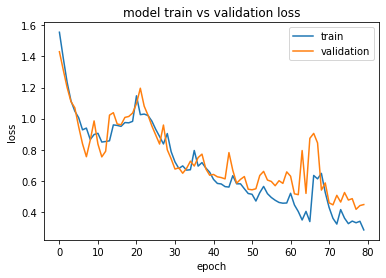

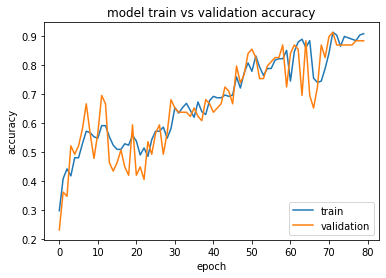

In [14]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig("C:/ML/loss"f"{starttime}.png")
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.savefig("C:/ML/accuracy_"f"{starttime}.png")
pyplot.show()

#### Underfit Example
Running this example produces a plot of train and validation loss showing the characteristic of an underfit model. In this case, performance may be improved by increasing the number of training epochs.


<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model.png" width="400">


Running this example shows the characteristic of an underfit model that appears under-provisioned.
In this case, performance may be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model-via-Status.png" width="400">

#### Good Fit Example
Running the example creates a line plot showing the train and validation loss meeting.
Ideally, we would like to see model performance like this if possible, although this may not be possible on challenging problems with a lot of data.

<img src="assets/Diagnostic-Line-Plot-Showing-a-Good-Fit-for-a-Model.png" width="400">

#### Overfit Example
Running this example creates a plot showing the characteristic inflection point in validation loss of an overfit model.
This may be a sign of too many training epochs.
In this case, the model training could be stopped at the inflection point. Alternately, the number of training examples could be increased.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Overfit-Model.png" width="400">

### Evaluate

In [ ]:
#model = tf.keras.models.load_model('./tmp/epoch49-0.90-0.39.hdf5')


bestmodel.evaluate(x=x_test, y=y_test, verbose=2)
#model.evaluate(x=x_test, y=y_test, verbose=2)


### Save model

In [ ]:
model.save("sign_lang_recognition_tuned.h5")